Let's get the data and prepare environment first. 

In [ ]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline
sns.set(context="notebook", style="darkgrid", palette="tab10")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [ ]:
# Get data from https://www.kaggle.com/c/tabular-playground-series-apr-2021 via Dropbox
! wget -O data.csv https://www.dropbox.com/s/m0cv354kl3pa27h/train.csv?dl=0

data = pd.read_csv('data.csv')
data.head()

--2022-03-07 15:54:17--  https://www.dropbox.com/s/m0cv354kl3pa27h/train.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/m0cv354kl3pa27h/train.csv [following]
--2022-03-07 15:54:17--  https://www.dropbox.com/s/raw/m0cv354kl3pa27h/train.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc39d57720c50309032c8d64b71b.dl.dropboxusercontent.com/cd/0/inline/BhBsN-Y2eLbNkt-mTFFhTHajZ3PdMAHHiuYvJuK8as5pzg6SL1XGNW3Upffi5c8dra6UxZZmNViVnm3dsfAJB0RKipc6iWv7aYjHcbwiNbbDnENf9D4UwOINfrzbJZDmIAzmMEmTQTvbVVqvQbVyvSTv/file# [following]
--2022-03-07 15:54:18--  https://uc39d57720c50309032c8d64b71b.dl.dropboxusercontent.com/cd/0/inline/BhBsN-Y2eLbNkt-mTFFhTHajZ3PdMAHHiuYvJuK8as5pzg6SL1XGNW3Upffi5c8dra6UxZZmNViVnm3dsfAJB0RKipc6iW

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


# Context

### Task
Perform data exploration and visualization without using the pandas_profiling library.







### Data overview 

The dataset is synthetic but based on a real dataset (in this case, the actual [Titanic data](https://www.kaggle.com/c/titanic/data)!) and generated using a CTGAN. The statistical properties of this dataset are very similar to the original Titanic dataset.

### Data structure

**Variable**|**Definition**|**Key**
:-----:|:-----:|:-----:
survival|Survival|0 = No, 1 = Yes
pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd
sex|Sex| 
Age|Age in years| 
sibsp|# of siblings / spouses aboard the Titanic| 
parch|# of parents / children aboard the Titanic| 
ticket|Ticket number| 
fare|Passenger fare| 
cabin|Cabin number| 
embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton

### Variable notes

**pclass**: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson
* Some children travelled only with a nanny, therefore parch=0 for them.

### Data application

Most likely data will be used to **predict survival of each passenger**, so the quality assesment will be done using this as data application. 



---



Let's change CamelCase names to snake_case 😉

In [ ]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower() for column in data.columns]

It looks like we had one extra column `PassengerId`. Let's check if it's unique and present and if so use it as index. 

In [ ]:
if not (data.passenger_id.duplicated() | data.passenger_id.isna()).any():
  data.set_index('passenger_id', inplace=True)

data.head()

,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
passenger_id,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


Let see what we've got after all:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   survived  100000 non-null  int64  
 1   pclass    100000 non-null  int64  
 2   name      100000 non-null  object 
 3   sex       100000 non-null  object 
 4   age       96708 non-null   float64
 5   sib_sp    100000 non-null  int64  
 6   parch     100000 non-null  int64  
 7   ticket    95377 non-null   object 
 8   fare      99866 non-null   float64
 9   cabin     32134 non-null   object 
 10  embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


# Data quality assessment

Let's work on each column one by one to assess quality and fix data in place if needed. 

### Survived

*No empty values*

In [ ]:
print("Values distribution")
data.survived.value_counts()

Values distribution


0    57226
1    42774
Name: survived, dtype: int64

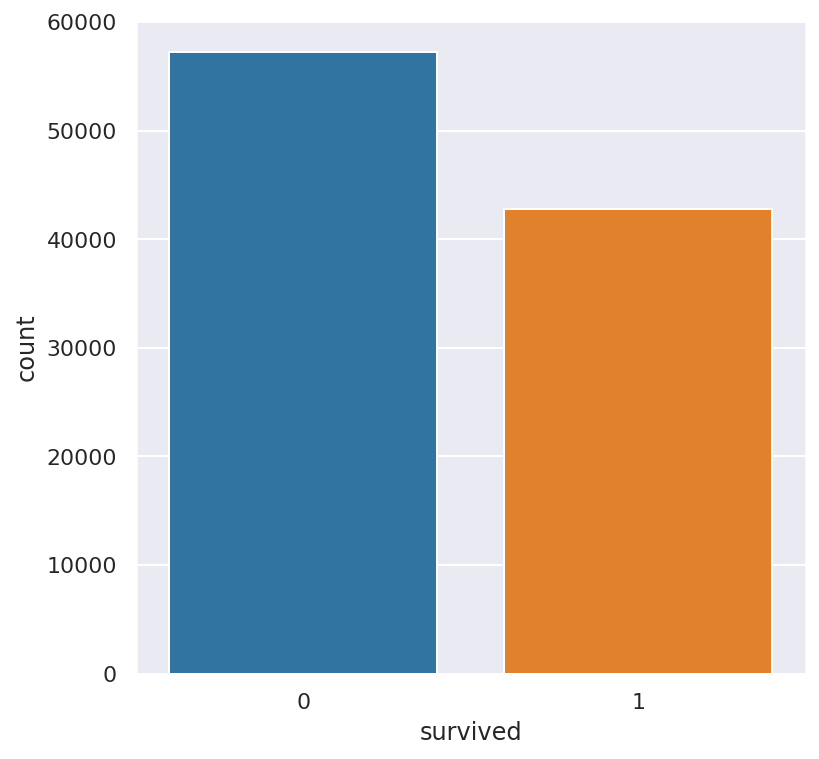

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x="survived");

`survived` target looks good.

### Sex

*No empty values*

In [ ]:
print("Values distribution")
data.sex.value_counts()

Values distribution


male      56114
female    43886
Name: sex, dtype: int64

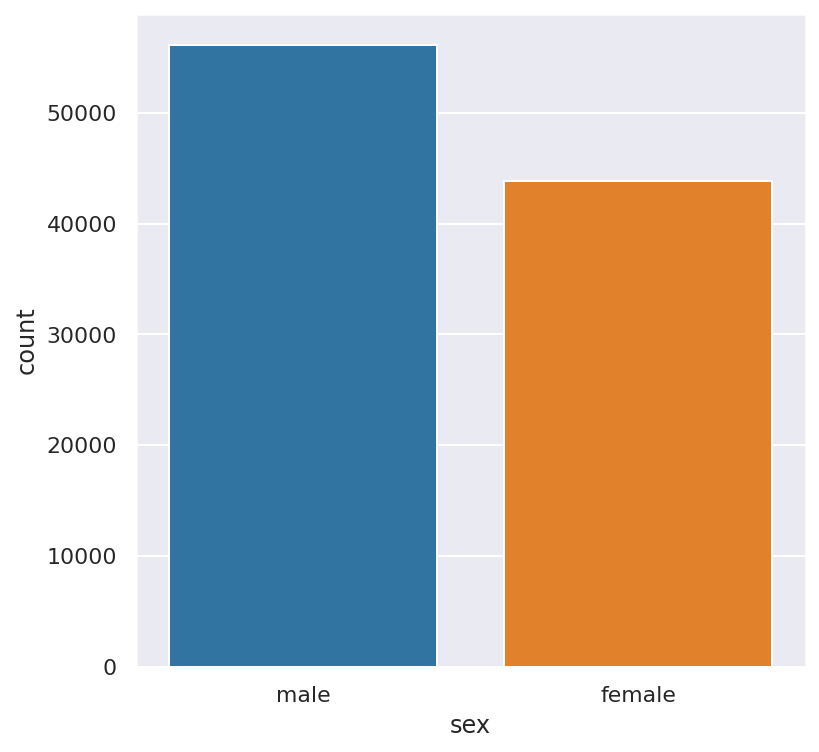

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x="sex");

`sex` feature looks good and almost balanced, don't think we need to do anything additionally, except switch it to int to be able to use it in learning process.

In [ ]:
sex_int = pd.factorize(data.sex)
print(f"replacing {sex_int[1].tolist()} with [0, 1]")
data.sex = sex_int[0]

replacing ['male', 'female'] with [0, 1]


### Pclass

Ticket class, a proxy for socio-economic status (SES)

*No empty values*

In [ ]:
print("Values distribution")
data.pclass.value_counts()

Values distribution


3    41006
1    30315
2    28679
Name: pclass, dtype: int64

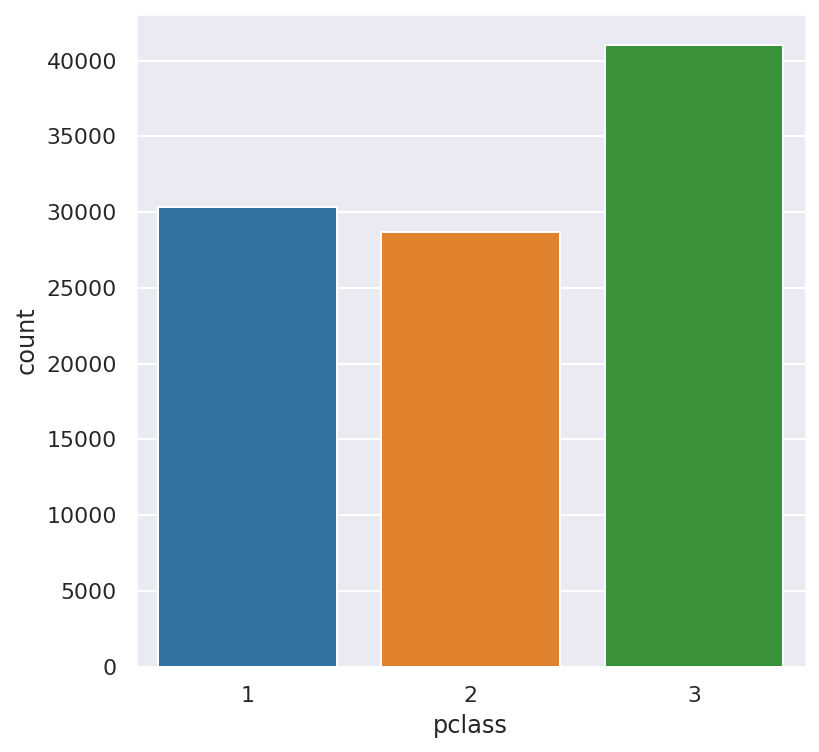

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x="pclass");

`pclass` feature a little bit disbalanced in favor of third class, but since we are not starting any ML right now - it's fine.

### Name

*No empty values*

In [ ]:
print("10 values sample")
data.name.sample(10)

10 values sample


passenger_id
58218    Christie, Gertrude
4377          Cooper, Linda
33305      Bennett, Richard
75959        Townson, Janet
36212       Lanzillo, Cathy
47472        Sanders, Diane
97424       Harris, Richard
4121           Craig, Brett
18950           Bode, Kevin
49895       Gordon, Patrick
Name: name, dtype: object

I'm not sure that we will be able to extract any valuable information regarding survavability based on names, so I will drop this column. 


In [ ]:
data.drop('name', axis=1, inplace=True)

### SibSp

\# of siblings / spouses aboard the Titanic

* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

*No empty values*

In [ ]:
print("Values distribution")
data.sib_sp.value_counts()

Values distribution


0    73308
1    19758
2     3703
3     1635
4     1168
8      296
5      132
Name: sib_sp, dtype: int64

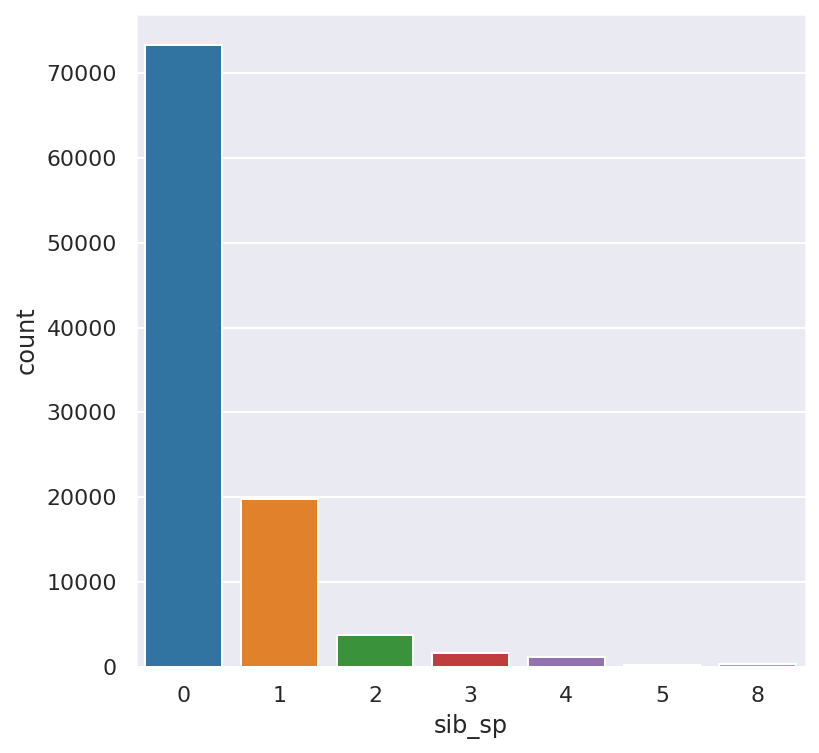

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x="sib_sp");

Distribution looks plausable. It seems we have quite a big families here.

### Parch

\# of parents / children aboard the Titanic	

The dataset defines family relations in this way...

* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson
* Some children travelled only with a nanny, therefore parch=0 for them.

*No empty values, very similar to SibSp*

In [ ]:
print("Values distribution")
data.parch.value_counts()

Values distribution


0    73540
1    12996
2    11236
3      983
4      446
5      331
9      264
6      204
Name: parch, dtype: int64

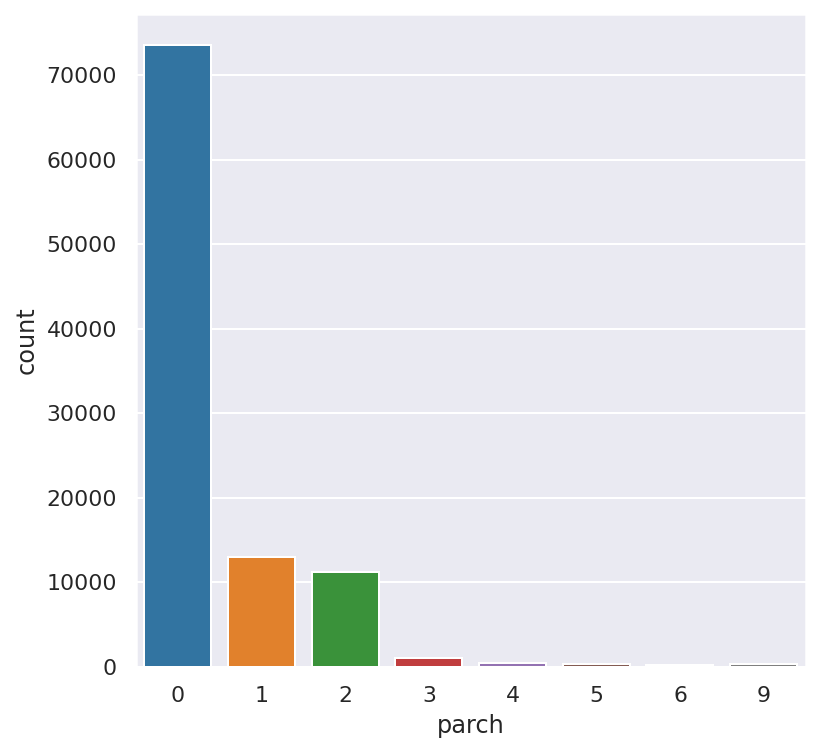

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(data=data, x="parch");

Distribution looks plausable. Someone had lots of children :)

### Age

*Some values are missing*

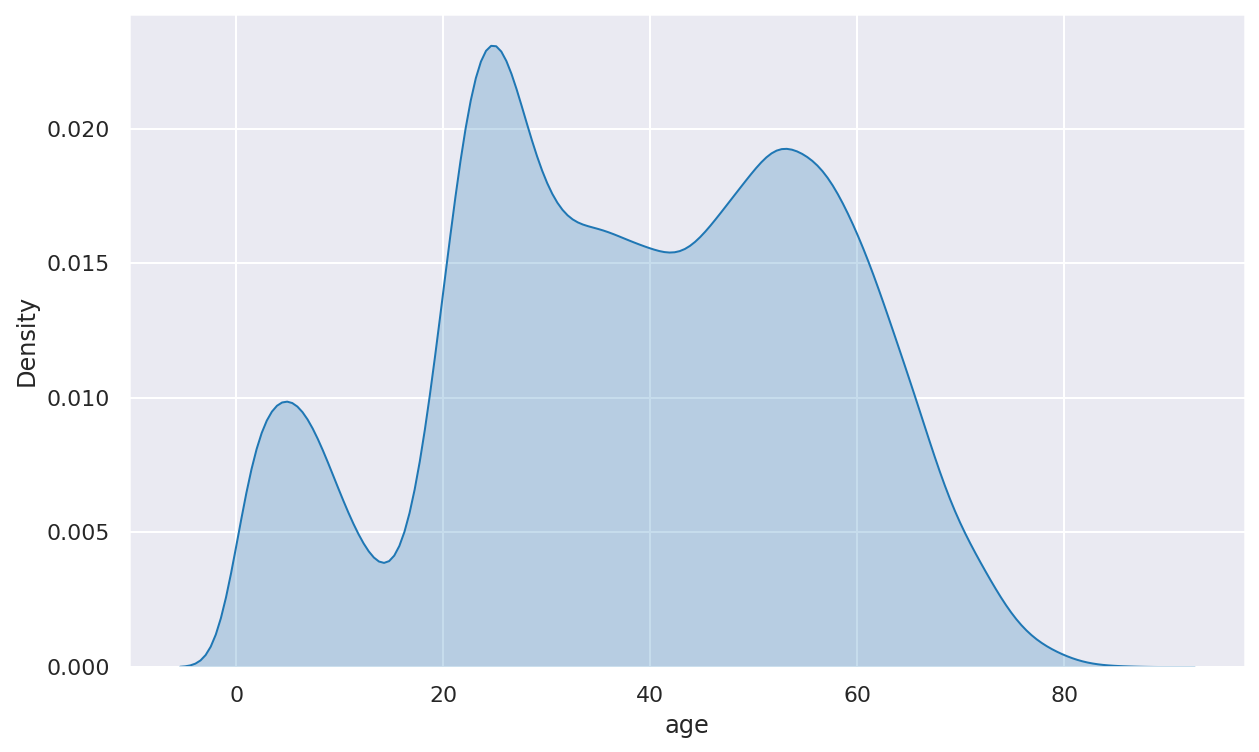

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x="age", fill=True);

Let check some unpopular values.

In [ ]:
data.age.value_counts().tail(10)

3.5     2
75.5    2
86.0    2
69.5    1
80.5    1
14.5    1
74.5    1
78.5    1
13.5    1
87.0    1
Name: age, dtype: int64

In [ ]:
print(f"not round values: {(data.age % 1 > 0).sum()}")

not round values: 1139


Let's round values, since I'm not sure that everyone was able to provide the right age with decimals.

In [ ]:
data.age = data.age.round()

Now is time to fix empty values. Since the distribution is rather complex let's look for some kind of dependency between different features and age.  

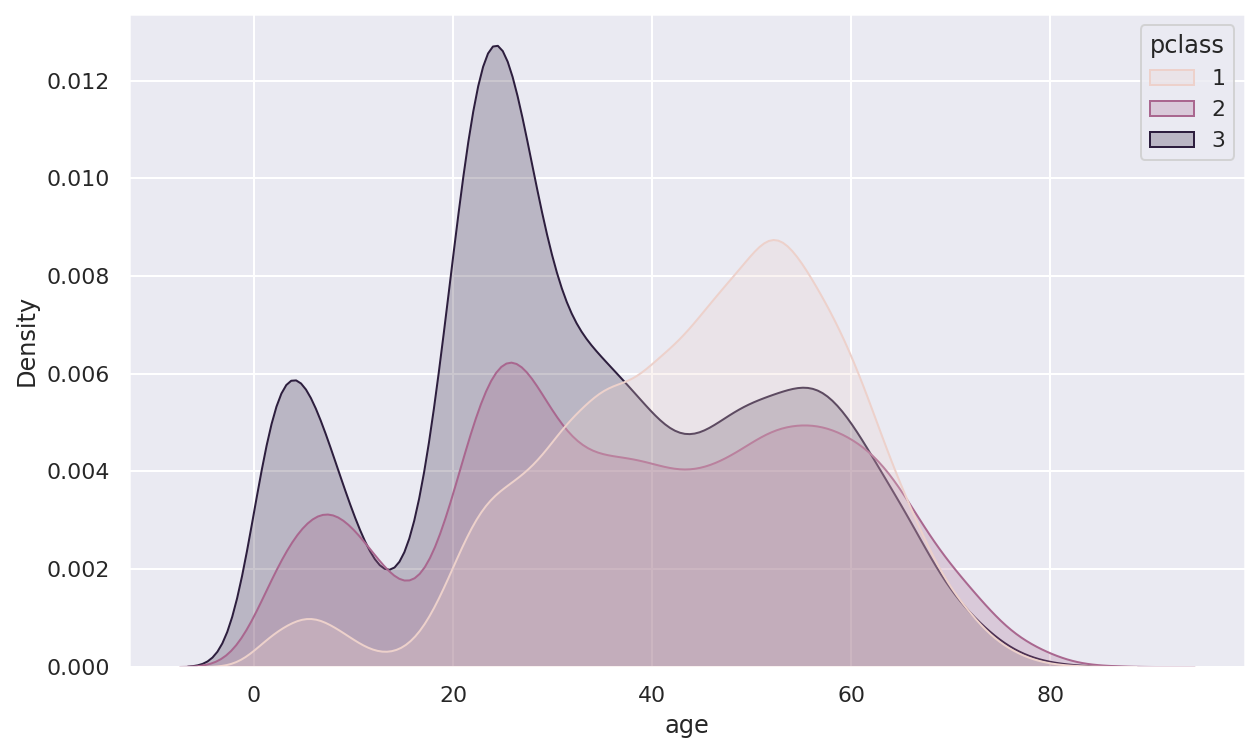

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x="age", hue='pclass', fill=True);

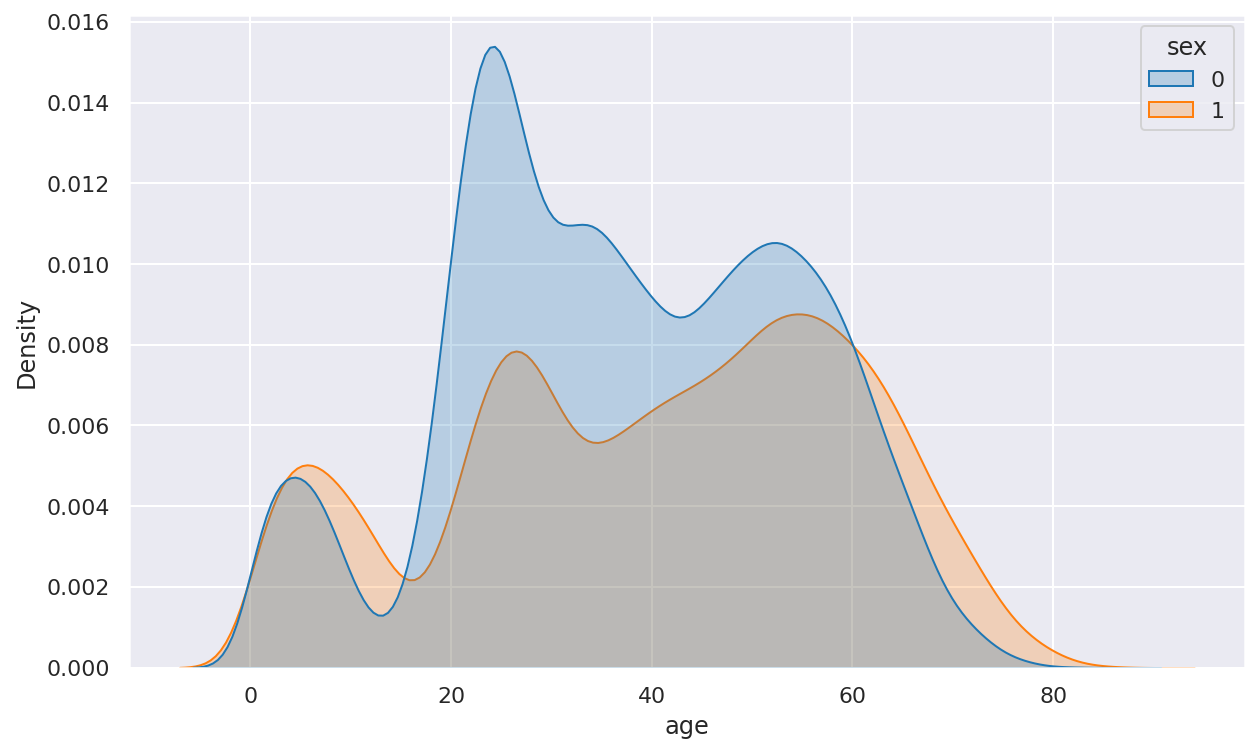

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x="age", hue='sex', fill=True);

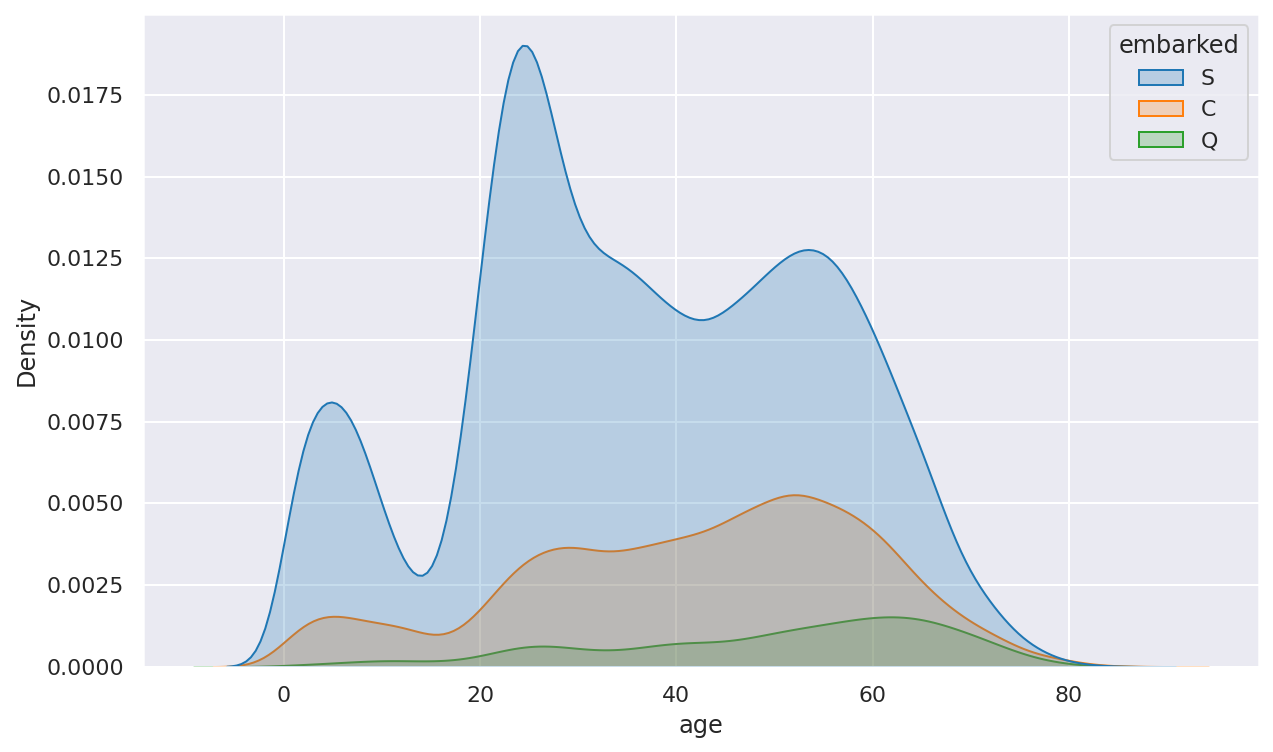

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x="age", hue='embarked', fill=True);

Looks like 3rd class is way more younger than other classes, the 1st class is very old, and mens in general younger. The best and simple predictor for `Age` is `Pclass`, let's use a median info from it to fill out empty values.

In [ ]:
for pclass in range(1,4):
  median = data[(data.pclass == pclass) & data.age.notna()].age.median()
  data.loc[(data.pclass == pclass) & data.age.isna(), 'age'] = median

Empty values: 0


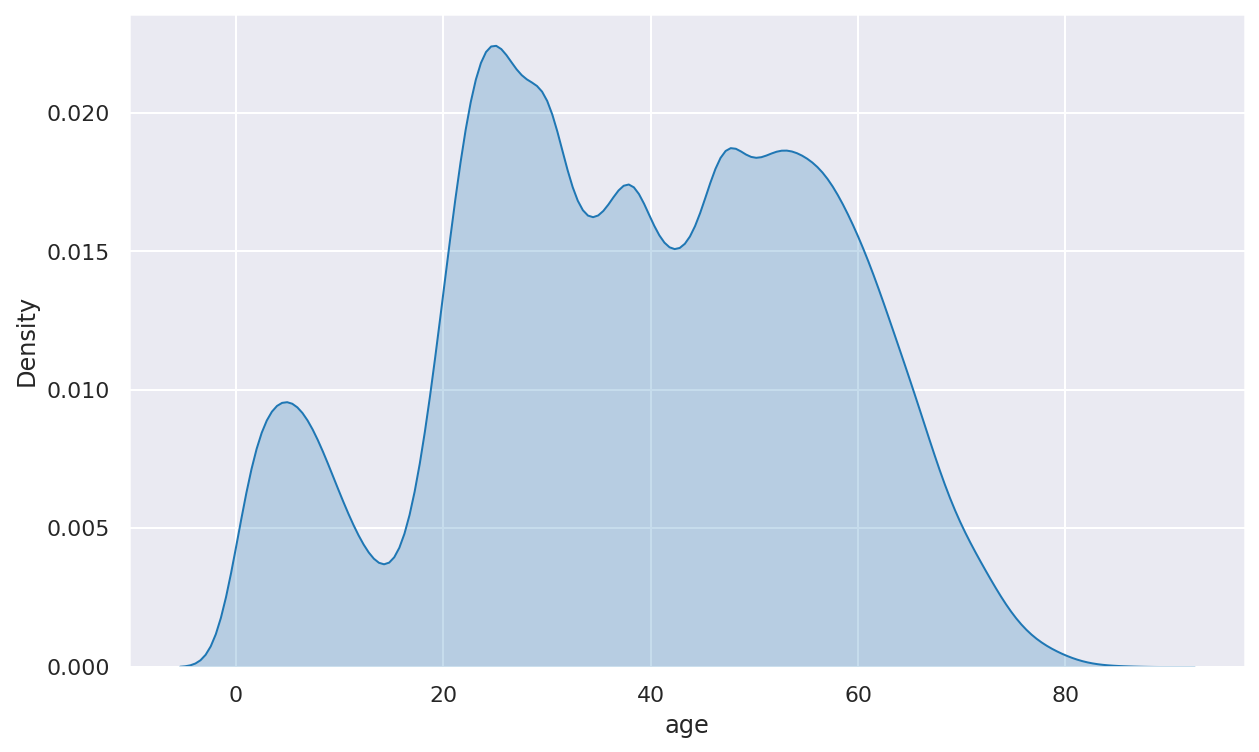

In [ ]:
print(f"Empty values: {data.age.isna().sum()}")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x="age", fill=True);

No empty values, a little bit strange peak, but I'm not sure we can do better here without linear regression. 

### Embarked

Port of Embarkation	

* C = Cherbourg
* Q = Queenstown
* S = Southampton

*Some values are missing*


In [ ]:
data.embarked.value_counts()

S    72139
C    22187
Q     5424
Name: embarked, dtype: int64

In [ ]:
data[data.embarked.isna()].survived.value_counts()

0    128
1    122
Name: survived, dtype: int64

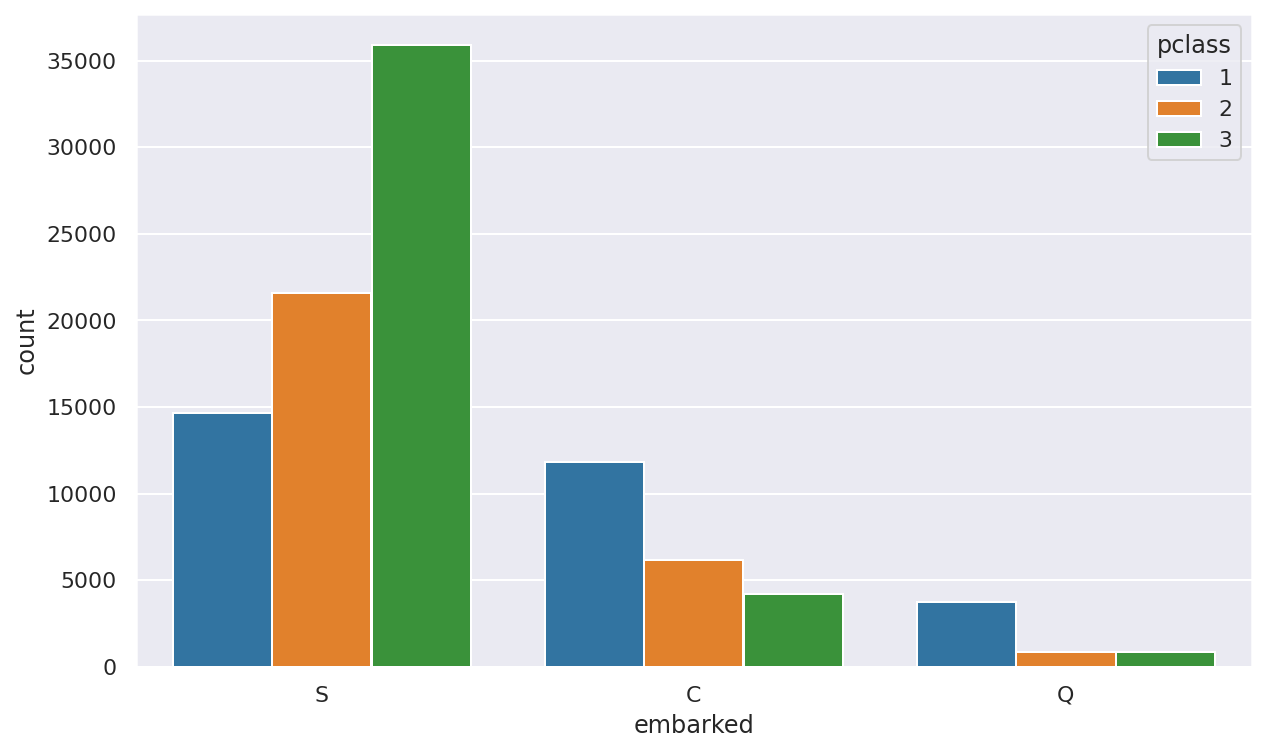

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="embarked", hue="pclass");

It seems that third class is mostly embarked on Southampton, and 1st class on Queenstown or Cheerbourg. We can use it as an indicator to fill small amount of empty values.

In [ ]:
data.loc[data.pclass.isin([2,3]) & data.embarked.isna(), 'embarked'] = "S"
data.loc[data.embarked.isna(), 'embarked'] = "Q"

In [ ]:
embarked_int = pd.factorize(data.embarked)
print(f"replacing {embarked_int[1].tolist()} with [1, 2, 3]")
data.embarked = embarked_int[0] + 1

replacing ['S', 'C', 'Q'] with [1, 2, 3]


### Cabin

*Most of values are missing*

I think we need to drop it. 

In [ ]:
data.drop('cabin', axis=1, inplace=True)

### Fare

*Small amount of values are missing*

In [ ]:
data.fare.isna().sum()

134

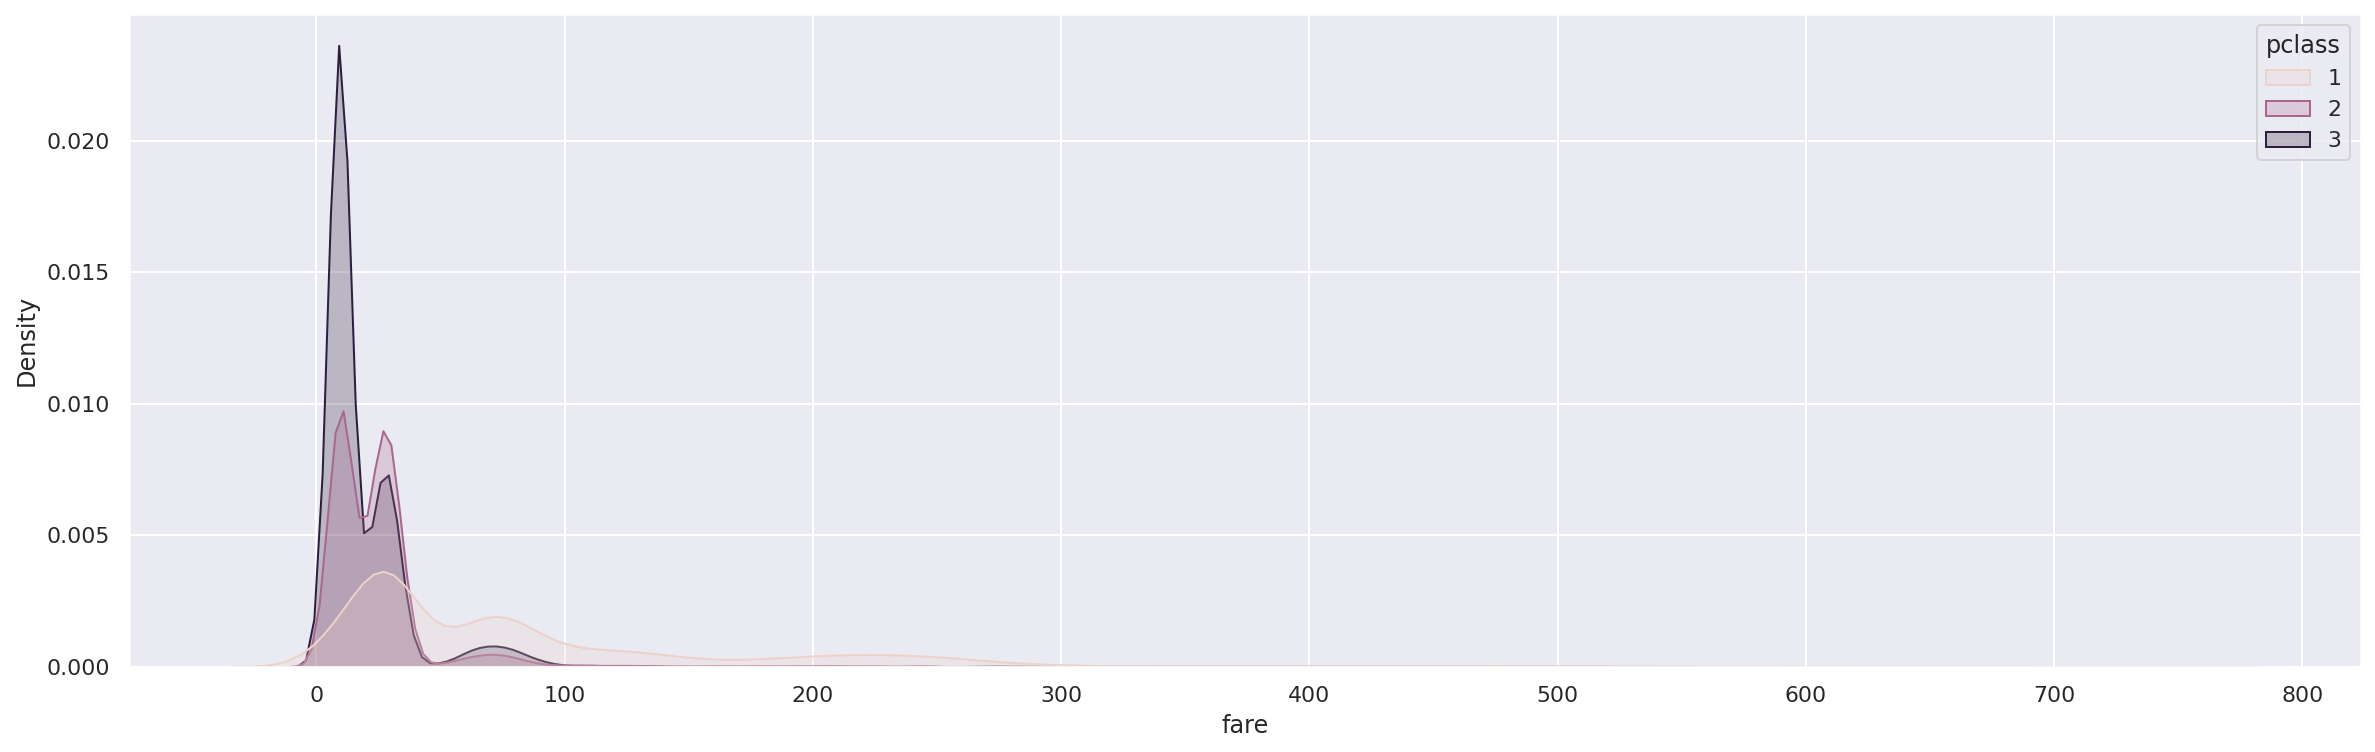

In [ ]:
plt.figure(figsize=(20, 6))
sns.kdeplot(data=data, x="fare", hue="pclass", fill=True);

It seems there was several types of tickets/fares and 1st class has the longest range of prices up to 800+. We can use `Pclass` to predict `median` fare.

In [ ]:
for pclass in range(1,4):
  median = data[(data.pclass == pclass) & data.fare.notna()].fare.median()
  data.loc[(data.pclass == pclass) & data.fare.isna(), 'fare'] = median

### Ticket

Ticket number

*Some values are missing*

In [ ]:
data.ticket.sample(10)

passenger_id
65998            454287
41200             14821
47681             43559
34570    STON/O 3968469
70158            316880
91513     S.O.C. 203122
56348              7646
18651            455318
85105             10142
61231            496986
Name: ticket, dtype: object

Since it's not numeric and it's in different format it will be hard to get anything from this data, we can use this data as label for ticket availability. Someone might travel without ticket.  

In [ ]:
data['has_ticket'] = data.ticket.notna().astype('int')
data.drop('ticket', axis=1, inplace=True)

### FamilitySize

I would like to add family size feature to have a total number of family mambers 

In [ ]:
data['family_size'] = data.sib_sp + data.parch

# Data exploration

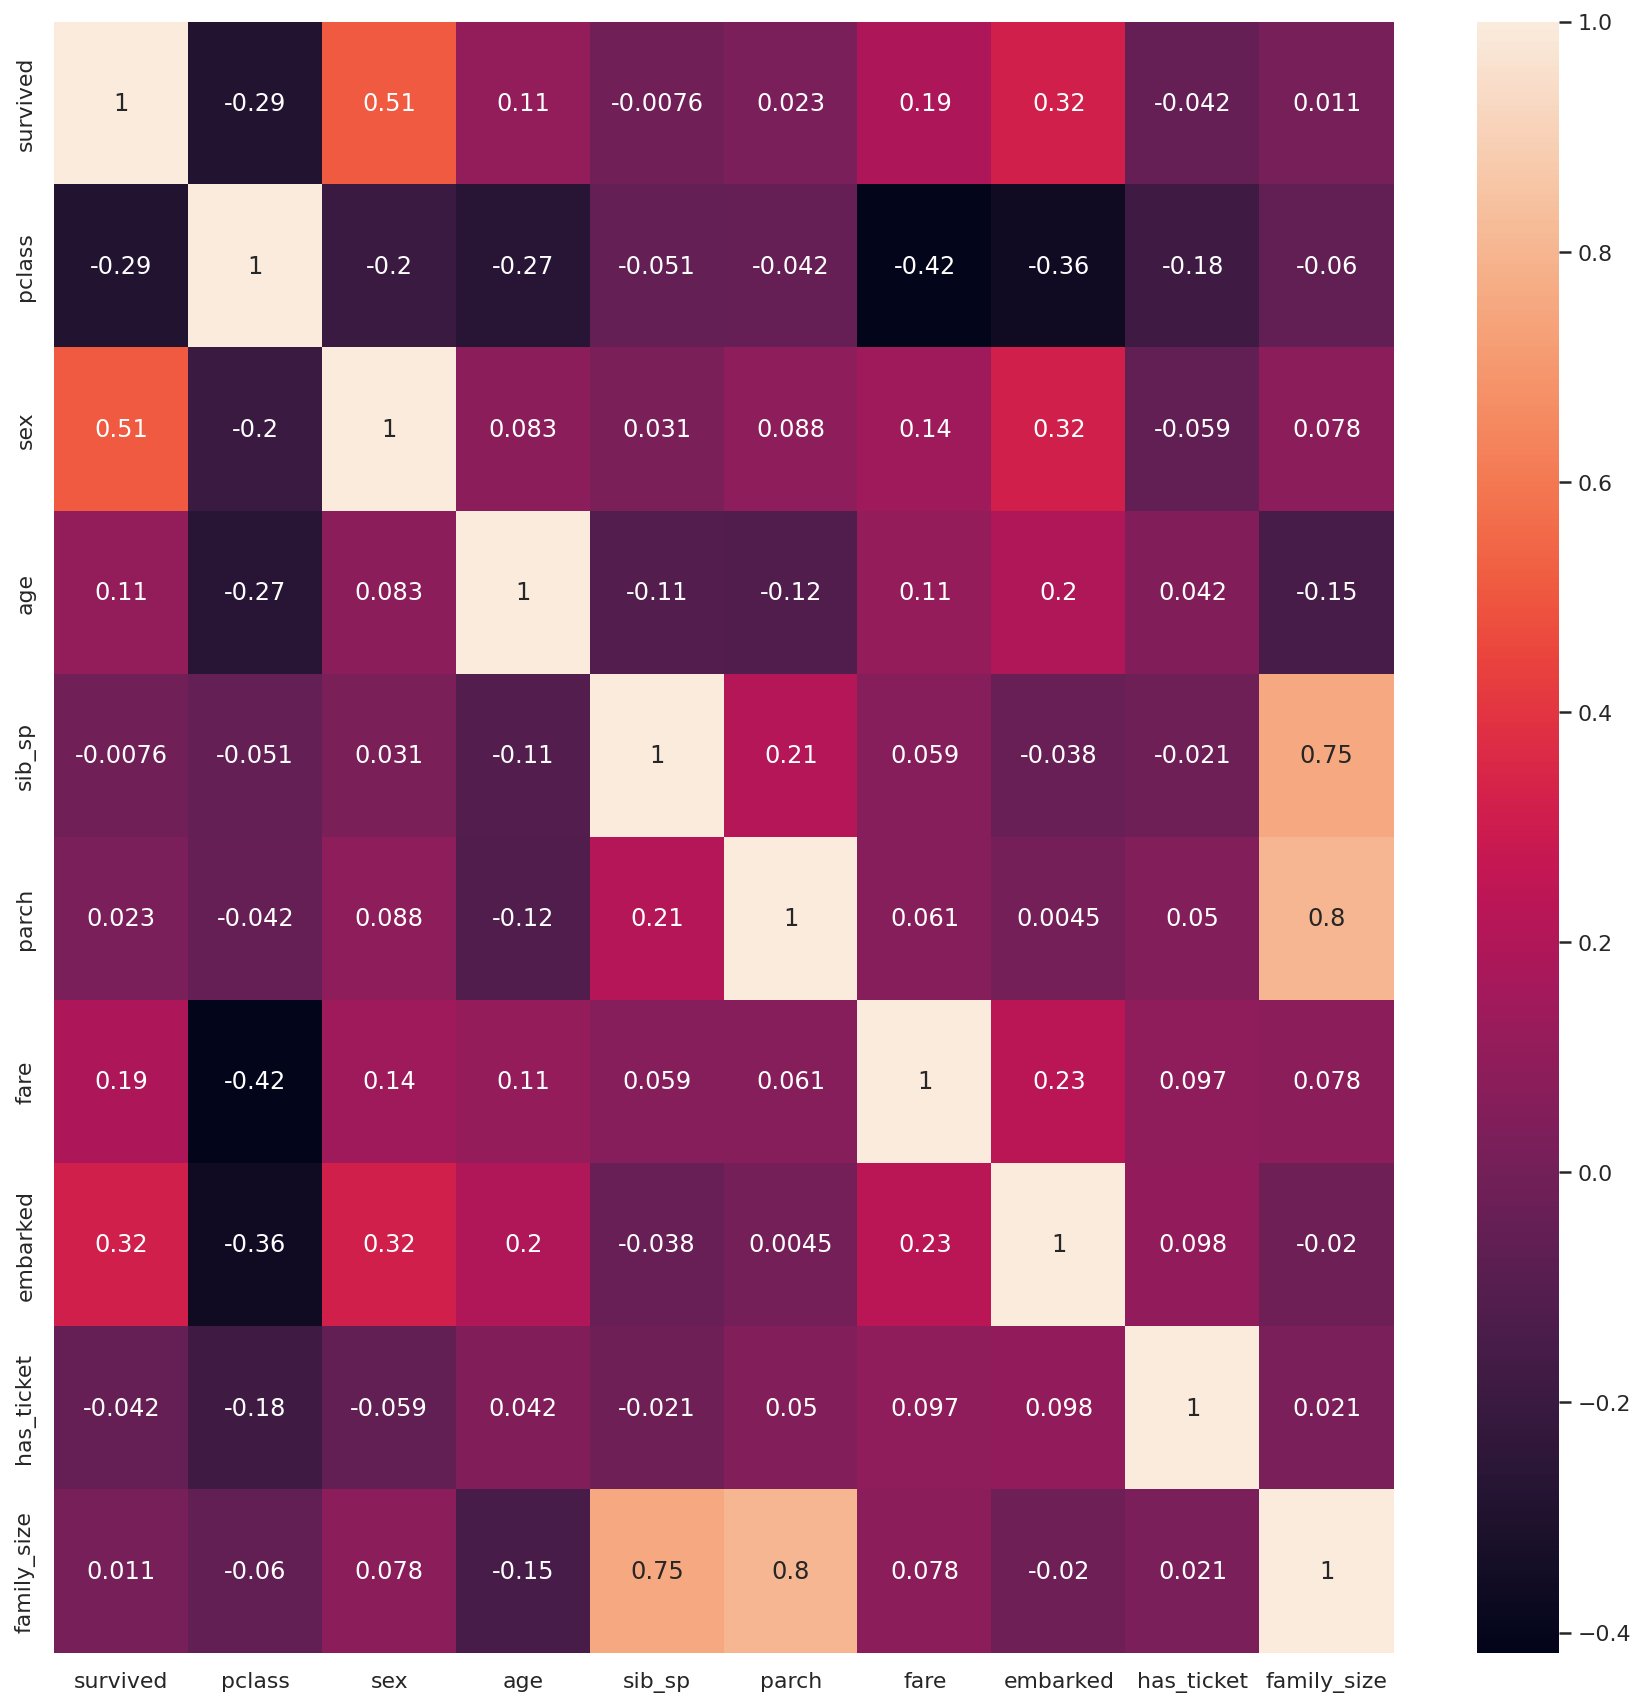

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data=data.corr(), annot=True);

* The better class - the more chances to survive 
* Women has much more chances to survive, this is the best preddictor for survavability
* Older people shows better survaval rates - seems to be correlated with class
* The embarkment showing correlation with survaval rate, but that may be because of low survival rate of 3rd class which embarked on Southampton
* Number of childrens positively relate to survaval rate. 


# Summary

In additional to previous block:
* We have a three age cohorts at this ship - ~12 yo, ~25 yo, ~50 yo.
* Looks like 3rd class is way more younger than other classes, the 1st class is very old, and mens in general younger. 
* It seems that third class is mostly embarked on Southampton, and 1st class on Queenstown or Cheerbourg. 
* It seems there was several types of tickets/fares and 1st class has the longest range of prices up to 800+. 